In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.poutine as poutine

import os
from prior import guide_prior, model_prior
from performance import analysis, utils

In [2]:
batch_size = 128
resize = 32
shape_simple_net = [-1, 32*32]
shape_lenet = [-1, 1, 32, 32]

In [3]:
transform_train = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

transform_test = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

In [4]:
test_loader_mnist = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=False, download=True, transform=transform_test),
    batch_size=batch_size, shuffle=True)

test_loader_fashion = torch.utils.data.DataLoader(
        datasets.FashionMNIST('fashion-mnist-data/', train=False, download=True, transform=transform_test),
        batch_size=batch_size, shuffle=True)
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# network

In [5]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(32*32, 1024)
        self.out = nn.Linear(1024, 10)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output

In [6]:
class LeNet(nn.Module):
    def __init__(self, num_classes, inputs=1):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(inputs, 6, 5, stride=1, bias=False)
        self.conv2 = nn.Conv2d(6, 16, 5, stride=1, bias=False)
        self.fc1 = nn.Linear(16*5*5, 120, bias=False)
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.fc3 = nn.Linear(84, num_classes, bias=False)

    def forward(self, x):
        out = F.max_pool2d(F.softplus(self.conv1(x)), 2)
        out = F.max_pool2d(F.softplus(self.conv2(out)), 2)
        out = out.view(out.size(0), -1)
        out = F.softplus(self.fc1(out))
        out = F.softplus(self.fc2(out))
        out = self.fc3(out)
        return out

# bayesian network

In [7]:
class SimpleBayesianNet(nn.Module):
    def __init__(self, use_cuda=False):
        super(SimpleBayesianNet, self).__init__()
        self.net = NN()
        self.log_softmax = nn.LogSoftmax(dim=1)
        
        if use_cuda:
            self.cuda()
    
    def model(self, x_data, y_data):
        fc1w_prior = model_prior.normal_prior(self.net.fc1.weight)
        fc1b_prior = model_prior.normal_prior(self.net.fc1.bias)

        outw_prior = model_prior.normal_prior(self.net.out.weight)
        outb_prior = model_prior.normal_prior(self.net.out.bias)

        priors = {
            'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,
            'out.weight': outw_prior, 'out.bias': outb_prior
        }

        # lift module parameters to random variables sampled from the priors
        lifted_module = pyro.random_module("module", self.net, priors)

        # sample a classifier
        lifted_reg_model = lifted_module()

        p_hat = self.log_softmax(lifted_reg_model(x_data))

        pyro.sample("obs", Categorical(logits=p_hat), obs=y_data)
    
    def guide(self, x_data, y_data):
        # fc1 weight distribution priors
        fc1w_prior = guide_prior.standard_normal_prior('fc1w', self.net.fc1.weight)
        # fc1 bias distribution priors
        fc1b_prior = guide_prior.standard_normal_prior('fc1b', self.net.fc1.bias)

        # fc3 weight distribution priors
        outw_prior = guide_prior.standard_normal_prior('outw', self.net.out.weight)
        # fc3 bias distribution priors
        outb_prior = guide_prior.standard_normal_prior('outb', self.net.out.bias)

        priors = {
            'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,
            'out.weight': outw_prior, 'out.bias': outb_prior
        }

        lifted_module = pyro.random_module("module", self.net, priors)
        return lifted_module()

In [8]:
class LenetBayesian(nn.Module):
    def __init__(self, use_cuda=False):
        super(LenetBayesian, self).__init__()
        self.net = LeNet(10, 1)
        self.log_softmax = nn.LogSoftmax(dim=1)
        
        if use_cuda:
            self.cuda()
    
    def model(self, x, y):
        conv1w_prior = model_prior.normal_prior(self.net.conv1.weight)
        conv2w_prior = model_prior.normal_prior(self.net.conv2.weight)
        fc1w_prior = model_prior.normal_prior(self.net.fc1.weight)
        fc2w_prior = model_prior.normal_prior(self.net.fc2.weight)
        fc3w_prior = model_prior.normal_prior(self.net.fc3.weight)
        
        priors = {
            'conv1.weight':conv1w_prior,
            'conv2.weight':conv2w_prior, 
            'fc1.weight': fc1w_prior,
            'fc2.weight':fc2w_prior,
            'fc3.weight':fc3w_prior
        }
        
        # lift module parameters to random variables sampled from the priors
        lifted_module = pyro.random_module("module", self.net, priors)
        
        # sample a classifier
        lifted_reg_model = lifted_module()
        
        p_hat = self.log_softmax(lifted_reg_model(x))
        
        with pyro.plate('observe_data'):
            pyro.sample("obs", Categorical(logits=p_hat), obs=y)
    
    def guide(self, x, y):
        conv1w_prior = guide_prior.mean_field_normal_prior('conv1w',self.net.conv1.weight)
        conv2w_prior = guide_prior.mean_field_normal_prior('conv2w',self.net.conv2.weight)
        fc1w_prior = guide_prior.mean_field_normal_prior('fc1w',self.net.fc1.weight)
        fc2w_prior = guide_prior.mean_field_normal_prior('fc2w', self.net.fc2.weight)
        fc3w_prior = guide_prior.mean_field_normal_prior('fc3w',self.net.fc3.weight)
        
        priors = {
            'conv1.weight':conv1w_prior,
            'conv2.weight':conv2w_prior, 
            'fc1.weight': fc1w_prior,
            'fc2.weight':fc2w_prior,
            'fc3.weight':fc3w_prior
        }
        lifted_module = pyro.random_module("module", self.net, priors)
        return lifted_module()

# load model

In [9]:
lenet = LenetBayesian()

simple_net = SimpleBayesianNet()

# simple net

In [10]:
pyro.clear_param_store()
model_path = './save_model'
pyro.get_param_store().load(os.path.join(model_path, 'simple_bayesian_model'))
pyro.module('module', lenet.net, update_module_params=True)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (fc1): Linear(in_features=400, out_features=120, bias=False)
  (fc2): Linear(in_features=120, out_features=84, bias=False)
  (fc3): Linear(in_features=84, out_features=10, bias=False)
)

# Lenet

In [199]:
pyro.clear_param_store()
model_path = './save_model'
pyro.get_param_store().load(os.path.join(model_path, 'lenet_bayesian_model'))
pyro.module('module', lenet.net, update_module_params=True)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (fc1): Linear(in_features=400, out_features=120, bias=False)
  (fc2): Linear(in_features=120, out_features=84, bias=False)
  (fc3): Linear(in_features=84, out_features=10, bias=False)
)

# What model doesn't know

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
from PIL import Image
from scipy.misc import imread
import math
import pandas as pd
from sklearn import metrics

## Empirical Probability

In [211]:
prob_simple_unscale, cum_simple_unscale = analysis.empirical_cdf_prob(test_loader_fashion, simple_net.guide, shape_simple_net, T=10, use_cuda=True)
prob_simple_scale, cum_simple_scale = analysis.empirical_cdf_prob(test_loader_fashion, simple_net.guide, shape_simple_net, T=10, use_cuda=True, scale=True, num_class=10)

In [200]:
prob_lenet_unscale, cum_lenet_unscale = analysis.empirical_cdf_prob(test_loader_fashion, lenet.guide, shape_lenet, T=10, use_cuda=True)
prob_lenet_scale, cum_lenet_scale = analysis.empirical_cdf_prob(test_loader_fashion, lenet.guide, shape_lenet, T=10, use_cuda=True, scale=True, num_class=10)

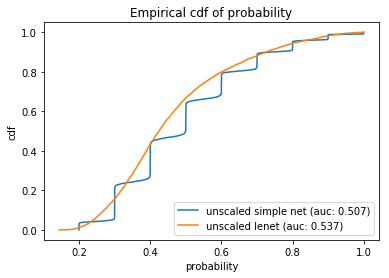

In [201]:
auc_simple = metrics.auc(prob_simple_unscale, cum_simple_unscale/cum_simple_unscale[-1])
auc_lenet = metrics.auc(prob_lenet_unscale, cum_lenet_unscale/cum_lenet_unscale[-1])

plt.figure()
plt.plot(prob_simple_unscale, cum_simple_unscale/cum_simple_unscale[-1], label='unscaled simple net (auc: %.3f)'%auc_simple)
plt.plot(prob_lenet_unscale, cum_lenet_unscale/cum_lenet_unscale[-1], label='unscaled lenet (auc: %.3f)' % auc_lenet)
plt.title('Empirical cdf of probability')
plt.xlabel('probability')
plt.ylabel('cdf')
plt.legend()
plt.show()
plt.close()

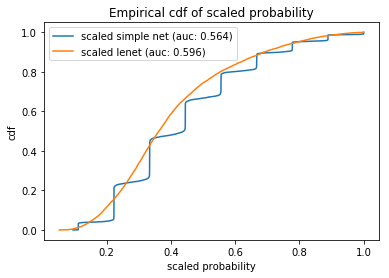

In [202]:
auc_simple = metrics.auc(prob_simple_scale, cum_simple_scale/cum_simple_scale[-1])
auc_lenet = metrics.auc(prob_lenet_scale, cum_lenet_scale/cum_lenet_scale[-1])

plt.figure()
plt.plot(prob_simple_scale, cum_simple_scale/cum_simple_scale[-1], label='scaled simple net (auc: %.3f)'%auc_simple)
plt.plot(prob_lenet_scale, cum_lenet_scale/cum_lenet_scale[-1], label='scaled lenet (auc: %.3f)' % auc_lenet)
plt.title('Empirical cdf of scaled probability')
plt.xlabel('scaled probability')
plt.ylabel('cdf')
plt.legend()
plt.show()
plt.close()

## Uncertainty Estimation

In [11]:
def uncertainty_distribution(uncertainty, prob, n_bins=10, scaled=False, n_class=10):
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    if scaled:
        prob = (prob - 1/n_class)/(1 - 1/n_class)

    prob_list = []
    uncertainty_list = []
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = prob.gt(bin_lower.item()) * prob.le(bin_upper.item())
        uncertainty_list.append(torch.mean(uncertainty[in_bin]).item())
        prob_list.append((bin_lower.item() + bin_upper.item()) / 2)
    return prob_list, uncertainty_list

In [14]:
alea_simple, epis_simple, prob_simple, label_simple = utils.uncertainty(test_loader_fashion, simple_net.guide, shape_simple_net, T=10, use_cuda=True)
confidence_simple, predictions_simple = torch.max(prob_simple, dim=1)
alea_simple = torch.tensor(np.choose(predictions_simple.numpy(), alea_simple.numpy().T))
epis_simple = torch.tensor(np.choose(predictions_simple.numpy(), epis_simple.numpy().T))
prob_simple_alea, uncertainty_simple_alea = uncertainty_distribution(alea_simple, confidence_simple)
prob_simple_epis, uncertainty_simple_epis = uncertainty_distribution(epis_simple, confidence_simple)

In [187]:
alea_lenet, epis_lenet, prob_lenet, label_lenet = utils.uncertainty(test_loader_fashion, lenet.guide, shape_lenet, T=10, use_cuda=True)
confidence_lenet, predictions_lenet = torch.max(prob_lenet, dim=1)
alea_lenet = torch.tensor(np.choose(predictions_lenet.numpy(), alea_lenet.numpy().T))
epis_lenet = torch.tensor(np.choose(predictions_lenet.numpy(), epis_lenet.numpy().T))
prob_lenet_alea, uncertainty_lenet_alea = uncertainty_distribution(alea_lenet, confidence_lenet)
prob_lenet_epis, uncertainty_lenet_epis = uncertainty_distribution(epis_lenet, confidence_lenet)

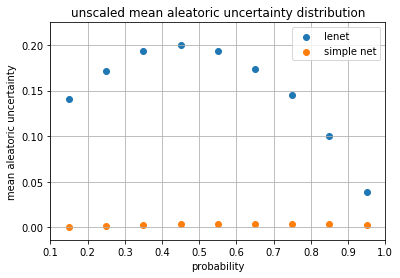

In [173]:
plt.figure()
plt.scatter(prob_lenet_alea, uncertainty_lenet_alea,label='lenet')
plt.scatter(prob_simple_alea, uncertainty_simple_alea, label='simple net')
plt.title('unscaled mean aleatoric uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean aleatoric uncertainty')
plt.legend()
plt.grid()
plt.show()
plt.close()

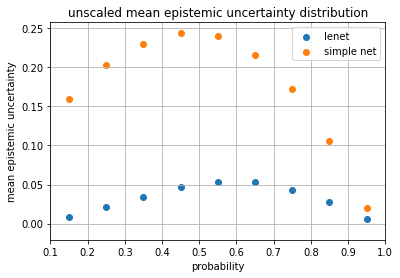

In [174]:
plt.figure()
plt.scatter(prob_lenet_epis, uncertainty_lenet_epis,label='lenet')
plt.scatter(prob_simple_epis, uncertainty_simple_epis, label='simple net')
plt.title('unscaled mean epistemic uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean epistemic uncertainty')
plt.legend()
plt.grid()
plt.show()
plt.close()

In [34]:
prob_simple_alea_scale, uncertainty_simple_alea_scale = uncertainty_distribution(alea_simple, (confidence_simple-1/10)/(1-1/10))
prob_simple_epis_scale, uncertainty_simple_epis_scale = uncertainty_distribution(epis_simple, (confidence_simple-0.1)/(1-0.1))

In [35]:
prob_lenet_alea_scale, uncertainty_lenet_alea_scale = uncertainty_distribution(alea_lenet, (confidence_lenet-0.1)/(1-0.1))
prob_lenet_epis_scale, uncertainty_lenet_epis_scale = uncertainty_distribution(epis_lenet, (confidence_lenet-0.1)/(1-0.1))

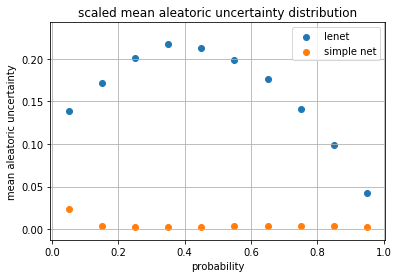

In [36]:
plt.figure()
plt.scatter(prob_lenet_alea_scale, uncertainty_lenet_alea_scale,label='lenet')
plt.scatter(prob_simple_alea_scale, uncertainty_simple_alea_scale, label='simple net')
plt.title('scaled mean aleatoric uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean aleatoric uncertainty')
plt.legend()
plt.grid()
plt.show()
plt.close()

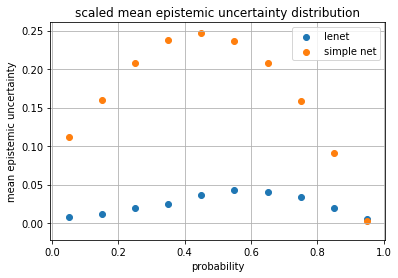

In [37]:
plt.figure()
plt.scatter(prob_lenet_epis_scale, uncertainty_lenet_epis_scale,label='lenet')
plt.scatter(prob_simple_epis_scale, uncertainty_simple_epis_scale, label='simple net')
plt.title('scaled mean epistemic uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean epistemic uncertainty')
plt.legend()
plt.grid()
plt.show()
plt.close()

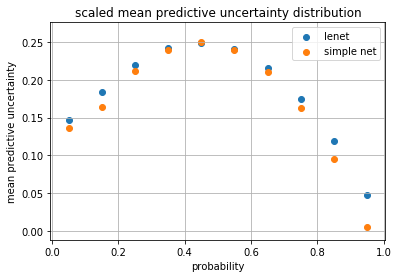

In [135]:
plt.figure()
plt.scatter(prob_lenet_epis_scale, np.array(uncertainty_lenet_epis_scale) + np.array(uncertainty_lenet_alea_scale),label='lenet')
plt.scatter(prob_simple_epis_scale, np.array(uncertainty_simple_epis_scale)+np.array(uncertainty_simple_alea_scale), label='simple net')
plt.title('scaled mean predictive uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean predictive uncertainty')
plt.legend()
plt.grid()
plt.show()
plt.close()

# what a model know

## calibration error (ECE)

In [41]:
simple_ece_loss = analysis.ece_loss_cal(test_loader_mnist, simple_net.guide, shape_simple_net, use_cuda=True)
print('ece loss for simple net: ', simple_ece_loss)

ece loss for simple net:  tensor([0.0288])


In [44]:
lenet_ece_loss = analysis.ece_loss_cal(test_loader_mnist, lenet.guide, shape_lenet, use_cuda=True)
print('ece loss for lenet: ', lenet_ece_loss)

ece loss for lenet:  tensor([0.0120])


## calibration error (RD)

In [58]:
simple_rd_x, simple_rd_y = analysis.reliability_diagram(test_loader_mnist, simple_net.guide, shape_simple_net,n_bins=10,use_cuda=True)

In [56]:
lenet_rd_x, lenet_rd_y = analysis.reliability_diagram(test_loader_mnist, lenet.guide, shape_lenet, n_bins=10,use_cuda=True)

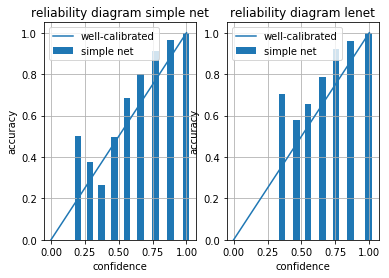

In [59]:
plt.figure()
plt.subplot(1,2,1)
plt.bar(simple_rd_x, simple_rd_y, width=0.05,label='simple net')
plt.plot(np.array(list(range(0,11)))/10., np.array(list(range(0,11)))/10., label='well-calibrated')
plt.title('reliability diagram simple net')
plt.xlabel('confidence')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.subplot(1,2,2)
plt.bar(lenet_rd_x, lenet_rd_y,width=0.05, label='simple net')
plt.plot(np.array(list(range(0,11)))/10., np.array(list(range(0,11)))/10., label='well-calibrated')
plt.title('reliability diagram lenet')
plt.xlabel('confidence')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()
plt.close()

## uncertainty in same distribution

In [15]:
alea_simple_mnist, epis_simple_mnist, prob_simple_mnist, label_simple_mnist = utils.uncertainty(test_loader_mnist, simple_net.guide, shape_simple_net, T=10, use_cuda=True)
confidence_simple_mnist, predictions_simple_mnist = torch.max(prob_simple_mnist, dim=1)
alea_simple_mnist = torch.tensor(np.choose(predictions_simple_mnist.numpy(), alea_simple_mnist.numpy().T))
epis_simple_mnist = torch.tensor(np.choose(predictions_simple_mnist.numpy(), epis_simple_mnist.numpy().T))
prob_simple_alea_mnist, uncertainty_simple_alea_mnist = uncertainty_distribution(alea_simple_mnist, confidence_simple_mnist)
prob_simple_epis_mnist, uncertainty_simple_epis_mnist = uncertainty_distribution(epis_simple_mnist, confidence_simple_mnist)

In [188]:
alea_lenet_mnist, epis_lenet_mnist, prob_lenet_mnist, label_lenet_mnist = utils.uncertainty(test_loader_mnist, lenet.guide, shape_lenet, T=10, use_cuda=True)
confidence_lenet_mnist, predictions_lenet_mnist = torch.max(prob_lenet_mnist, dim=1)
alea_lenet_mnist = torch.tensor(np.choose(predictions_lenet_mnist.numpy(), alea_lenet_mnist.numpy().T))
epis_lenet_mnist = torch.tensor(np.choose(predictions_lenet_mnist.numpy(), epis_lenet_mnist.numpy().T))
prob_lenet_alea_mnist, uncertainty_lenet_alea_mnist = uncertainty_distribution(alea_lenet_mnist, confidence_lenet_mnist)
prob_lenet_epis_mnist, uncertainty_lenet_epis_mnist = uncertainty_distribution(epis_lenet_mnist, confidence_lenet_mnist)

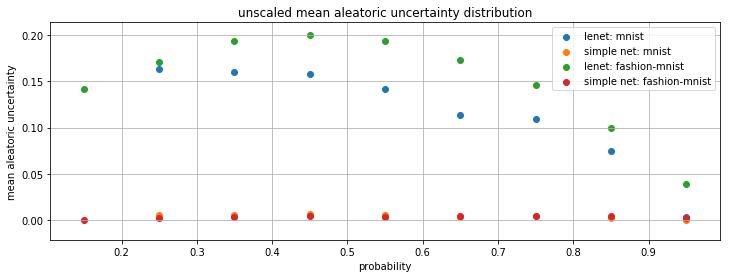

In [180]:
plt.figure(figsize=(12,4))
plt.scatter(prob_lenet_alea_mnist, uncertainty_lenet_alea_mnist,label='lenet: mnist')
plt.scatter(prob_simple_alea_mnist, uncertainty_simple_alea_mnist, label='simple net: mnist')
plt.scatter(prob_lenet_alea, uncertainty_lenet_alea,label='lenet: fashion-mnist')
plt.scatter(prob_simple_alea, uncertainty_simple_alea, label='simple net: fashion-mnist')
plt.title('unscaled mean aleatoric uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean aleatoric uncertainty')
plt.legend()
plt.grid()
plt.show()
plt.close()

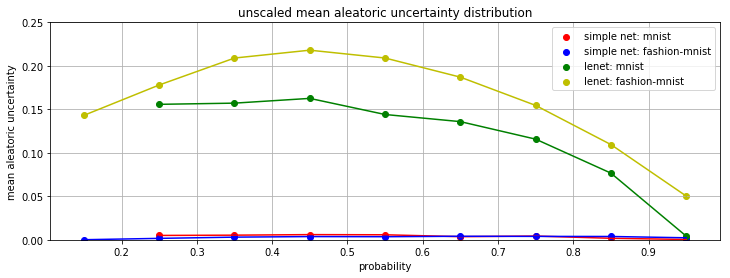

In [190]:
plt.figure(figsize=(12,4))
plt.scatter(prob_simple_alea_mnist, uncertainty_simple_alea_mnist ,label='simple net: mnist', c='r')
plt.scatter(prob_simple_alea, uncertainty_simple_alea,label='simple net: fashion-mnist', c='b')
plt.plot(prob_simple_alea_mnist, uncertainty_simple_alea_mnist, c='r')
plt.plot(prob_simple_alea, uncertainty_simple_alea, c='b')

plt.scatter(prob_lenet_alea_mnist, uncertainty_lenet_alea_mnist,label='lenet: mnist', c='g')
plt.scatter(prob_lenet_alea, uncertainty_lenet_alea,label='lenet: fashion-mnist', c='y')
plt.plot(prob_lenet_alea_mnist, uncertainty_lenet_alea_mnist, c='g')
plt.plot(prob_lenet_alea, uncertainty_lenet_alea, c='y')

plt.title('unscaled mean aleatoric uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean aleatoric uncertainty')
plt.ylim(0, 0.25)
plt.legend()
plt.grid()
plt.show()
plt.close()

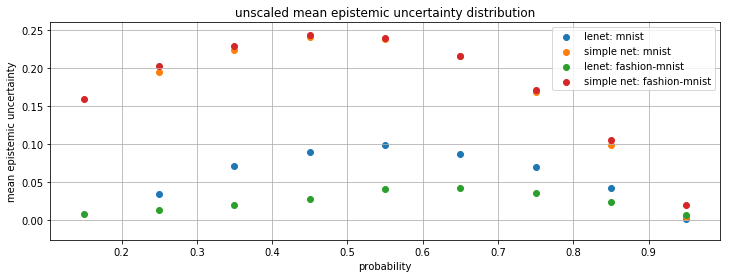

In [70]:
plt.figure(figsize=(12,4))
plt.scatter(prob_lenet_epis_mnist, uncertainty_lenet_epis_mnist,label='lenet: mnist')
plt.scatter(prob_simple_epis_mnist, uncertainty_simple_epis_mnist, label='simple net: mnist')
plt.scatter(prob_lenet_epis, uncertainty_lenet_epis,label='lenet: fashion-mnist')
plt.scatter(prob_simple_epis, uncertainty_simple_epis, label='simple net: fashion-mnist')
plt.title('unscaled mean epistemic uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean epistemic uncertainty')
plt.legend()
plt.grid()
plt.show()
plt.close()

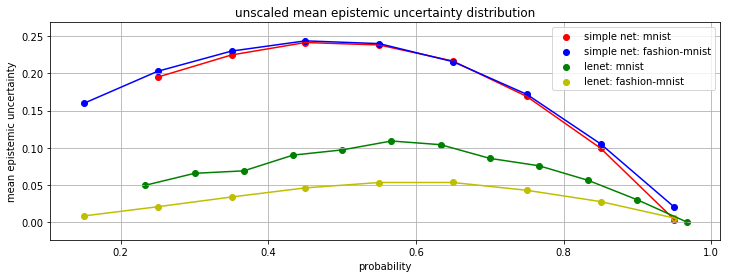

In [185]:
plt.figure(figsize=(12,4))
plt.scatter(prob_simple_epis_mnist, uncertainty_simple_epis_mnist, label='simple net: mnist', c='r')
plt.scatter(prob_simple_epis, uncertainty_simple_epis, label='simple net: fashion-mnist', c='b')
plt.scatter(prob_lenet_epis_mnist, uncertainty_lenet_epis_mnist,label='lenet: mnist', c='g')
plt.scatter(prob_lenet_epis, uncertainty_lenet_epis,label='lenet: fashion-mnist', c='y')

plt.plot(prob_simple_epis_mnist, uncertainty_simple_epis_mnist, c='r')
plt.plot(prob_simple_epis, uncertainty_simple_epis, c='b')
plt.plot(prob_lenet_epis_mnist, uncertainty_lenet_epis_mnist, c='g')
plt.plot(prob_lenet_epis, uncertainty_lenet_epis, c='y')

plt.title('unscaled mean epistemic uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean epistemic uncertainty')
plt.legend()
plt.grid()
plt.show()
plt.close()

In [68]:
prob_simple_alea_scale_mnist, uncertainty_simple_alea_scale_mnist = uncertainty_distribution(alea_simple_mnist, (confidence_simple_mnist-1/10)/(1-1/10))
prob_simple_epis_scale_mnist, uncertainty_simple_epis_scale_mnist = uncertainty_distribution(epis_simple_mnist, (confidence_simple_mnist-0.1)/(1-0.1))

In [69]:
prob_lenet_alea_scale_mnist, uncertainty_lenet_alea_scale_mnist = uncertainty_distribution(alea_lenet_mnist, (confidence_lenet_mnist-0.1)/(1-0.1))
prob_lenet_epis_scale_mnist, uncertainty_lenet_epis_scale_mnist = uncertainty_distribution(epis_lenet_mnist, (confidence_lenet_mnist-0.1)/(1-0.1))

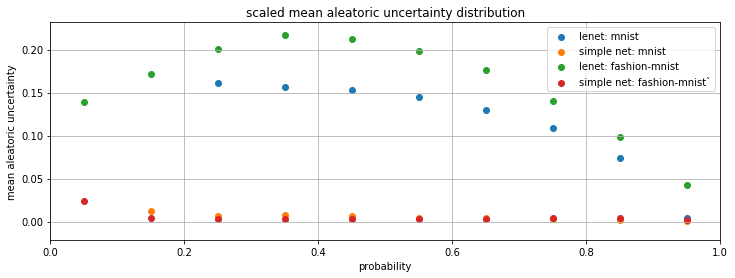

In [71]:
plt.figure(figsize=(12,4))
plt.scatter(prob_lenet_alea_scale_mnist, uncertainty_lenet_alea_scale_mnist,label='lenet: mnist')
plt.scatter(prob_simple_alea_scale_mnist, uncertainty_simple_alea_scale_mnist, label='simple net: mnist')
plt.scatter(prob_lenet_alea_scale, uncertainty_lenet_alea_scale,label='lenet: fashion-mnist')
plt.scatter(prob_simple_alea_scale, uncertainty_simple_alea_scale, label='simple net: fashion-mnist`')
plt.title('scaled mean aleatoric uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean aleatoric uncertainty')
plt.legend()
plt.grid()
plt.show()
plt.close()

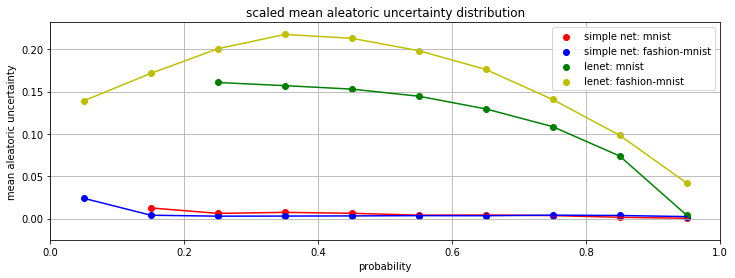

In [152]:
plt.figure(figsize=(12,4))
plt.scatter(prob_simple_alea_scale_mnist, uncertainty_simple_alea_scale_mnist, label='simple net: mnist', c='r')
plt.scatter(prob_simple_alea_scale, uncertainty_simple_alea_scale, label='simple net: fashion-mnist', c='b')
plt.scatter(prob_lenet_alea_scale_mnist, uncertainty_lenet_alea_scale_mnist,label='lenet: mnist', c='g')
plt.scatter(prob_lenet_alea_scale, uncertainty_lenet_alea_scale,label='lenet: fashion-mnist', c='y')



plt.plot(prob_lenet_alea_scale_mnist, uncertainty_lenet_alea_scale_mnist,'g')
plt.plot(prob_simple_alea_scale_mnist, uncertainty_simple_alea_scale_mnist,'r')
plt.plot(prob_lenet_alea_scale, uncertainty_lenet_alea_scale,'y')
plt.plot(prob_simple_alea_scale, uncertainty_simple_alea_scale,'b')
plt.title('scaled mean aleatoric uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean aleatoric uncertainty')
plt.legend()
plt.grid()
plt.show()
plt.close()

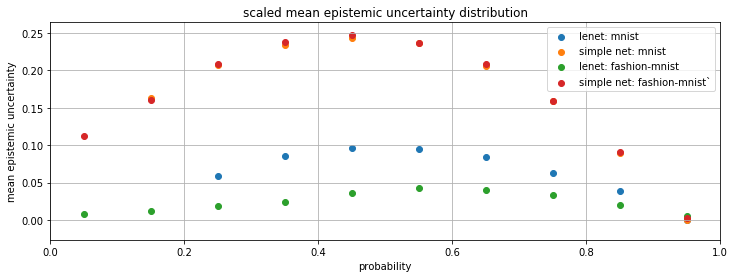

In [72]:
plt.figure(figsize=(12,4))
plt.scatter(prob_lenet_epis_scale_mnist, uncertainty_lenet_epis_scale_mnist,label='lenet: mnist')
plt.scatter(prob_simple_epis_scale_mnist, uncertainty_simple_epis_scale_mnist, label='simple net: mnist')
plt.scatter(prob_lenet_epis_scale, uncertainty_lenet_epis_scale,label='lenet: fashion-mnist')
plt.scatter(prob_simple_epis_scale, uncertainty_simple_epis_scale, label='simple net: fashion-mnist`')
plt.title('scaled mean epistemic uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean epistemic uncertainty')
plt.legend()
plt.grid()
plt.show()
plt.close()

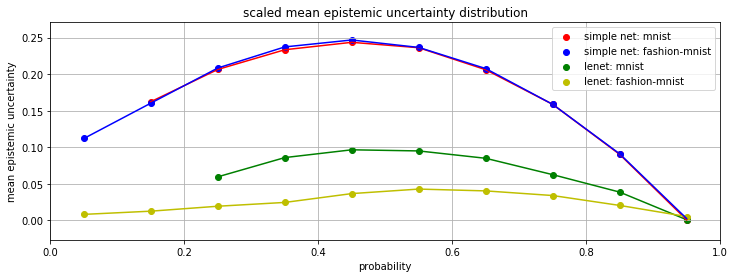

In [176]:
plt.figure(figsize=(12,4))

plt.scatter(prob_simple_epis_scale_mnist, uncertainty_simple_epis_scale_mnist, label='simple net: mnist', c='r')
plt.scatter(prob_simple_epis_scale, uncertainty_simple_epis_scale, label='simple net: fashion-mnist', c='b')
plt.scatter(prob_lenet_epis_scale_mnist, uncertainty_lenet_epis_scale_mnist,label='lenet: mnist', c='g')
plt.scatter(prob_lenet_epis_scale, uncertainty_lenet_epis_scale,label='lenet: fashion-mnist', c='y')


plt.plot(prob_lenet_epis_scale_mnist, uncertainty_lenet_epis_scale_mnist, 'g')
plt.plot(prob_simple_epis_scale_mnist, uncertainty_simple_epis_scale_mnist, 'r')
plt.plot(prob_lenet_epis_scale, uncertainty_lenet_epis_scale, 'y')
plt.plot(prob_simple_epis_scale, uncertainty_simple_epis_scale, 'b')

plt.title('scaled mean epistemic uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean epistemic uncertainty')
plt.legend()
plt.grid()
plt.show()
plt.close()

### predictive uncertainty 

In [80]:
# fashion mnist unscale
predictive_prob =  prob_simple_alea
predictive = np.array(uncertainty_simple_alea) + np.array(uncertainty_simple_epis)

predictive_prob_lenet = prob_lenet_alea
predictive_lenet = np.array(uncertainty_lenet_alea) + np.array(uncertainty_lenet_epis)

# fasion mnist scale
predictive_prob_scale = prob_simple_alea_scale
predictive_scale = np.array(uncertainty_simple_alea_scale) + np.array(uncertainty_simple_epis_scale)

predictive_prob_scale_lenet = prob_lenet_alea_scale
predictive_scale_lenet = np.array(uncertainty_lenet_alea_scale) + np.array(uncertainty_lenet_epis_scale)

# mnist unscale
predictive_prob_mnist = prob_simple_alea_mnist
predictive_mnist = np.array(uncertainty_simple_alea_mnist) + np.array(uncertainty_simple_epis_mnist)

predictive_prob_mnist_lenet = prob_lenet_alea_mnist
predictive_mnist_lenet = np.array(uncertainty_lenet_alea_mnist) + np.array(uncertainty_lenet_epis_mnist)

# mnist scale
predictive_prob_mnist_scale = prob_simple_alea_scale_mnist
predictive_mnist_scale = np.array(uncertainty_simple_alea_scale_mnist) + np.array(uncertainty_simple_epis_scale_mnist)

predictive_prob_mnist_scale_lenet = prob_lenet_alea_scale_mnist
predictive_mnist_scale_lenet = np.array(uncertainty_lenet_alea_scale_mnist) + np.array(uncertainty_lenet_epis_scale_mnist)

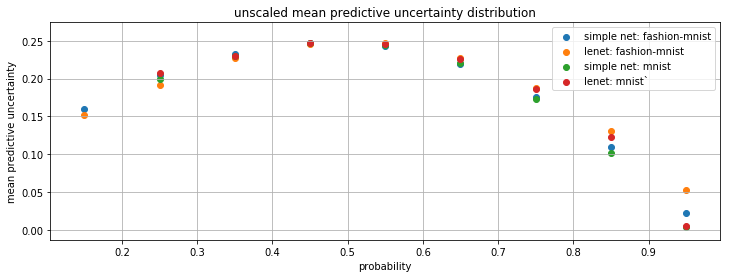

In [78]:
plt.figure(figsize=(12,4))
plt.scatter(predictive_prob, predictive, label='simple net: fashion-mnist')
plt.scatter(predictive_prob_lenet, predictive_lenet, label='lenet: fashion-mnist')
plt.scatter(predictive_prob_mnist, predictive_mnist,label='simple net: mnist')
plt.scatter(predictive_prob_mnist_lenet, predictive_mnist_lenet, label='lenet: mnist`')
plt.title('unscaled mean predictive uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean predictive uncertainty')
plt.legend()
plt.grid()
plt.show()
plt.close()

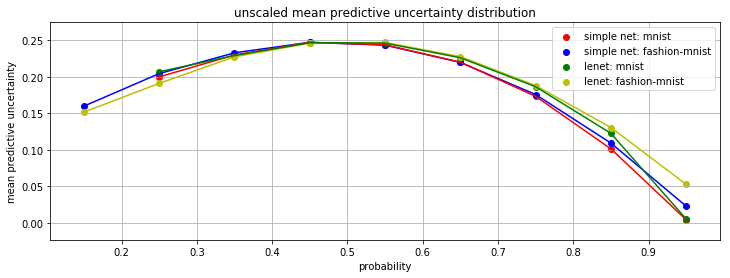

In [151]:
plt.figure(figsize=(12,4))
plt.scatter(predictive_prob_mnist, predictive_mnist,label='simple net: mnist', c='r')
plt.scatter(predictive_prob, predictive, label='simple net: fashion-mnist', c='b')
plt.scatter(predictive_prob_mnist_lenet, predictive_mnist_lenet, label='lenet: mnist', c='g')
plt.scatter(predictive_prob_lenet, predictive_lenet, label='lenet: fashion-mnist', c='y')

plt.plot(predictive_prob, predictive, c='b')
plt.plot(predictive_prob_lenet, predictive_lenet, c='y')
plt.plot(predictive_prob_mnist, predictive_mnist, c='r')
plt.plot(predictive_prob_mnist_lenet, predictive_mnist_lenet, c='g')

plt.title('unscaled mean predictive uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean predictive uncertainty')
plt.legend()
plt.grid()
plt.show()
plt.close()

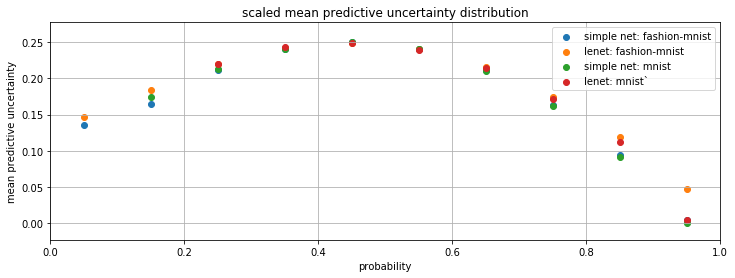

In [81]:
plt.figure(figsize=(12,4))
plt.scatter(predictive_prob_scale, predictive_scale, label='simple net: fashion-mnist')
plt.scatter(predictive_prob_scale_lenet, predictive_scale_lenet, label='lenet: fashion-mnist')
plt.scatter(predictive_prob_mnist_scale, predictive_mnist_scale,label='simple net: mnist')
plt.scatter(predictive_prob_mnist_scale_lenet, predictive_mnist_scale_lenet, label='lenet: mnist`')
plt.title('scaled mean predictive uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean predictive uncertainty')
plt.legend()
plt.grid()
plt.show()
plt.close()

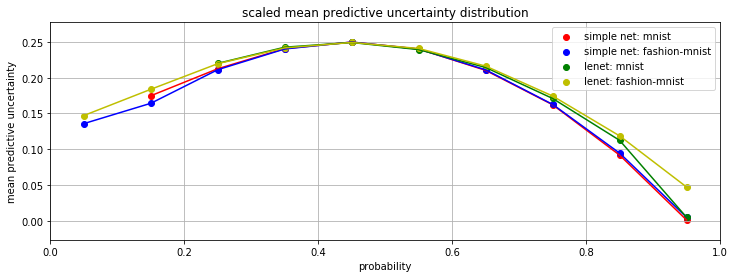

In [156]:
plt.figure(figsize=(12,4))
plt.scatter(predictive_prob_mnist_scale, predictive_mnist_scale,label='simple net: mnist', c='r')
plt.scatter(predictive_prob_scale, predictive_scale, label='simple net: fashion-mnist', c='b')
plt.scatter(predictive_prob_mnist_scale_lenet, predictive_mnist_scale_lenet, label='lenet: mnist', c='g')
plt.scatter(predictive_prob_scale_lenet, predictive_scale_lenet, label='lenet: fashion-mnist', c='y')

plt.plot(predictive_prob_mnist_scale, predictive_mnist_scale, c='r')
plt.plot(predictive_prob_scale, predictive_scale, c='b')
plt.plot(predictive_prob_mnist_scale_lenet, predictive_mnist_scale_lenet, c='g')
plt.plot(predictive_prob_scale_lenet, predictive_scale_lenet, c='y')

plt.title('scaled mean predictive uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean predictive uncertainty')
plt.legend()
plt.grid()
plt.show()
plt.close()

In [115]:
def average_uncertainty_divergence(uncertain_a, uncertain_b):
    if len(uncertain_a) != len(uncertain_b):
        return None
    else:
        return np.mean(np.abs(np.array(uncertain_a)-np.array(uncertain_b)))

## average uncertainty divergence (AUD)
the predictive uncertainty distribution is also be able to tell under what condition, the model is not be able to tell if a sample is come fome 

In [120]:
simple_aud = average_uncertainty_divergence(uncertainty_simple_alea_mnist, uncertainty_simple_alea)
print('aud aleatoric uncertainty for unscaled simple net: ', simple_aud)
lenet_aud = average_uncertainty_divergence(uncertainty_lenet_alea_mnist, uncertainty_lenet_alea)
print('aud aleatoric uncertainty for unscaled lenet:', lenet_aud)

simple_aud = average_uncertainty_divergence(uncertainty_simple_epis, uncertainty_simple_epis_mnist)
print('aud epistemic uncertainty for unscaled simple net: ', simple_aud)
lenet_aud = average_uncertainty_divergence(uncertainty_lenet_epis, uncertainty_lenet_epis_mnist)
print('aud epistmic uncertainty for unscaled lenet:', lenet_aud)

simple_aud = average_uncertainty_divergence(predictive, predictive_mnist)
print('aud predictive uncertainty for unscaled simple net: ', simple_aud)
lenet_aud = average_uncertainty_divergence(predictive_lenet, predictive_mnist_lenet)
print('aud predictive uncertainty for unscaled lenet:', lenet_aud)

print('=============>')
simple_aud = average_uncertainty_divergence(uncertainty_simple_alea_scale_mnist, uncertainty_simple_alea_scale)
print('aud aleatoric uncertainty for scaled simple net: ', simple_aud)
lenet_aud = average_uncertainty_divergence(uncertainty_lenet_alea_scale_mnist, uncertainty_lenet_alea_scale)
print('aud aleatoric uncertainty for scaled lenet:', lenet_aud)

simple_aud = average_uncertainty_divergence(uncertainty_simple_epis_scale_mnist, uncertainty_simple_epis_scale)
print('aud aleatoric uncertainty for scaled simple net: ', simple_aud)
lenet_aud = average_uncertainty_divergence(uncertainty_lenet_epis_scale_mnist, uncertainty_lenet_epis_scale)
print('aud aleatoric uncertainty for scaled lenet:', lenet_aud)

simple_aud = average_uncertainty_divergence(predictive_scale, predictive_mnist_scale)
print('aud aleatoric uncertainty for scaled simple net: ', simple_aud)
lenet_aud = average_uncertainty_divergence(predictive_scale_lenet, predictive_mnist_scale_lenet)
print('aud aleatoric uncertainty for scaled lenet:', lenet_aud)

aud aleatoric uncertainty for unscaled simple net:  0.0018729957591858692
aud aleatoric uncertainty for unscaled lenet: 0.040824091411195695
aud epistemic uncertainty for unscaled simple net:  0.00541626158519648
aud epistmic uncertainty for unscaled lenet: 0.03698433253885014
aud predictive uncertainty for unscaled simple net:  0.004653770542063285
aud predictive uncertainty for unscaled lenet: 0.009734144019603264
=============>
aud aleatoric uncertainty for scaled simple net:  0.0028104233723651203
aud aleatoric uncertainty for scaled lenet: 0.044390154303982854
aud aleatoric uncertainty for scaled simple net:  0.0017319876416068939
aud aleatoric uncertainty for scaled lenet: 0.03871468178840587
aud aleatoric uncertainty for scaled simple net:  0.002276386671130442
aud aleatoric uncertainty for scaled lenet: 0.007122392569726799


### describe the uncertainty of samples been correctly classified and samples been wrongly classified within each boundries

In [92]:
def uncertainty_correct_wrong(loader, guide, shape, n_bins=10, T=10, use_cuda=False, scaled=False, n_class=10):
    alea, epis, prob, label = utils.uncertainty(loader, guide, shape, T, use_cuda)
    confidence, predictions = torch.max(prob, dim=1)
    
    alea = torch.tensor(np.choose(predictions.numpy(), alea.numpy().T))
    epis = torch.tensor(np.choose(predictions.numpy(), epis.numpy().T))
    
    correct_idx = predictions.eq(label).gt(0)
    wrong_idx = predictions.eq(label).le(0)
    
    if scaled:
        confidence = (confidence - 1/n_class)/(1-1/n_class)
        
    prob_alea_correct, uncertainty_alea_correct = uncertainty_distribution(alea[correct_idx], confidence[correct_idx], n_bins=n_bins)
    prob_epis_correct, uncertainty_epis_correct = uncertainty_distribution(epis[correct_idx], confidence[correct_idx], n_bins=n_bins)

    prob_alea_wrong, uncertainty_alea_wrong = uncertainty_distribution(alea[wrong_idx], confidence[wrong_idx], n_bins=n_bins)
    prob_epis_wrong, uncertainty_epis_wrong = uncertainty_distribution(epis[wrong_idx], confidence[wrong_idx], n_bins=n_bins)
    
    return prob_alea_correct, uncertainty_alea_correct, uncertainty_epis_correct, uncertainty_alea_wrong, uncertainty_epis_wrong

In [85]:
prob_s, alea_correct_s, epis_correct_s, alea_wrong_s, epis_wrong_s = uncertainty_correct_wrong(test_loader_mnist, simple_net.guide, shape_simple_net, use_cuda=True)

In [87]:
prob_l, alea_correct_l, epis_correct_l, alea_wrong_l, epis_wrong_l = uncertainty_correct_wrong(test_loader_mnist, lenet.guide, shape_lenet, use_cuda=True)

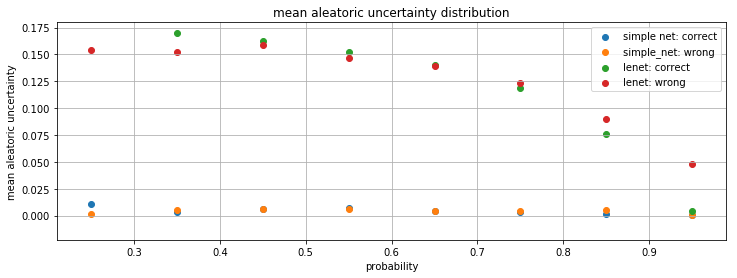

In [89]:
plt.figure(figsize=(12,4))
plt.scatter(prob_s, alea_correct_s, label='simple net: correct')
plt.scatter(prob_s, alea_wrong_s, label='simple_net: wrong')
plt.scatter(prob_l, alea_correct_l,label='lenet: correct')
plt.scatter(prob_l, alea_wrong_l, label='lenet: wrong')
plt.title('mean aleatoric uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean aleatoric uncertainty')
plt.legend()
plt.grid()
plt.show()
plt.close()

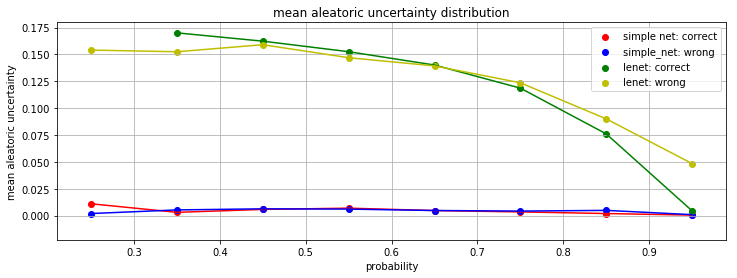

In [162]:
plt.figure(figsize=(12,4))
plt.scatter(prob_s, alea_correct_s, label='simple net: correct', c='r')
plt.scatter(prob_s, alea_wrong_s, label='simple_net: wrong', c='b')
plt.scatter(prob_l, alea_correct_l,label='lenet: correct', c='g')
plt.scatter(prob_l, alea_wrong_l, label='lenet: wrong',c='y')

plt.plot(prob_s, alea_correct_s,'r')
plt.plot(prob_s, alea_wrong_s, 'b')
plt.plot(prob_l, alea_correct_l, 'g')
plt.plot(prob_l, alea_wrong_l,'y')

plt.title('mean aleatoric uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean aleatoric uncertainty')
plt.legend()
plt.grid()
plt.show()
plt.close()

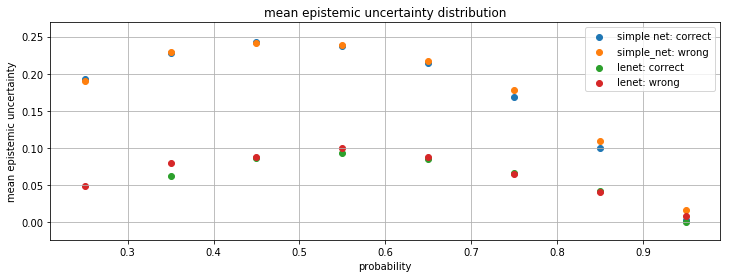

In [90]:
plt.figure(figsize=(12,4))
plt.scatter(prob_s, epis_correct_s, label='simple net: correct')
plt.scatter(prob_s, epis_wrong_s, label='simple_net: wrong')
plt.scatter(prob_l, epis_correct_l,label='lenet: correct')
plt.scatter(prob_l, epis_wrong_l, label='lenet: wrong')
plt.title('mean epistemic uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean epistemic uncertainty')
plt.legend()
plt.grid()
plt.show()
plt.close()

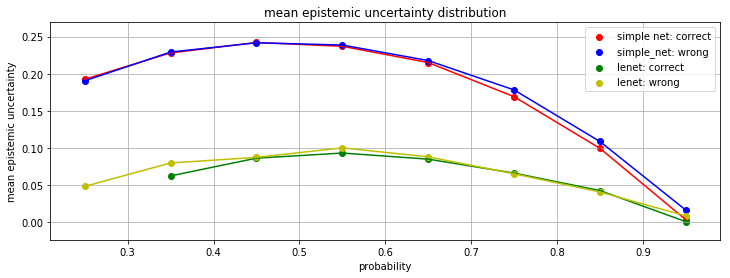

In [164]:
plt.figure(figsize=(12,4))
plt.scatter(prob_s, epis_correct_s, label='simple net: correct', c='r')
plt.scatter(prob_s, epis_wrong_s, label='simple_net: wrong', c='b')
plt.scatter(prob_l, epis_correct_l,label='lenet: correct', c='g')
plt.scatter(prob_l, epis_wrong_l, label='lenet: wrong', c='y')

plt.plot(prob_s, epis_correct_s, c='r')
plt.plot(prob_s, epis_wrong_s, c='b')
plt.plot(prob_l, epis_correct_l,c='g')
plt.plot(prob_l, epis_wrong_l, c='y')

plt.title('mean epistemic uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean epistemic uncertainty')
plt.legend()
plt.grid()
plt.show()
plt.close()

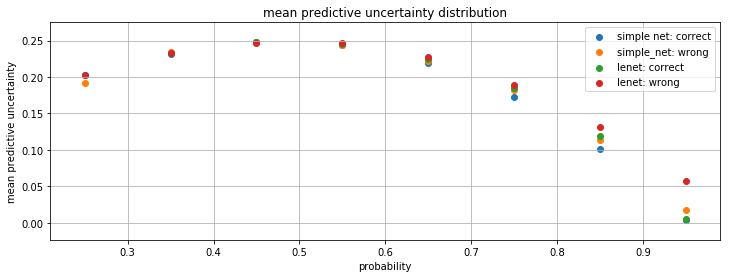

In [91]:
plt.figure(figsize=(12,4))
plt.scatter(prob_s, np.array(alea_correct_s) + np.array(epis_correct_s), label='simple net: correct')
plt.scatter(prob_s, np.array(alea_wrong_s) + np.array(epis_wrong_s), label='simple_net: wrong')
plt.scatter(prob_l, np.array(alea_correct_l) + np.array(epis_correct_l), label='lenet: correct')
plt.scatter(prob_l, np.array(alea_wrong_l) + np.array(epis_wrong_l), label='lenet: wrong')
plt.title('mean predictive uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean predictive uncertainty')
plt.legend()
plt.grid()
plt.show()
plt.close()

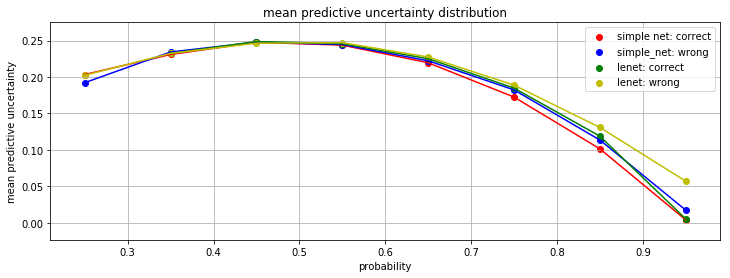

In [165]:
plt.figure(figsize=(12,4))
plt.scatter(prob_s, np.array(alea_correct_s) + np.array(epis_correct_s), label='simple net: correct', c='r')
plt.scatter(prob_s, np.array(alea_wrong_s) + np.array(epis_wrong_s), label='simple_net: wrong', c='b')
plt.scatter(prob_l, np.array(alea_correct_l) + np.array(epis_correct_l), label='lenet: correct', c='g')
plt.scatter(prob_l, np.array(alea_wrong_l) + np.array(epis_wrong_l), label='lenet: wrong', c='y')

plt.plot(prob_s, np.array(alea_correct_s) + np.array(epis_correct_s), c='r')
plt.plot(prob_s, np.array(alea_wrong_s) + np.array(epis_wrong_s), c='b')
plt.plot(prob_l, np.array(alea_correct_l) + np.array(epis_correct_l), c='g')
plt.plot(prob_l, np.array(alea_wrong_l) + np.array(epis_wrong_l), c='y')

plt.title('mean predictive uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean predictive uncertainty')
plt.legend()
plt.grid()
plt.show()
plt.close()

In [95]:
prob_s_scale, alea_correct_s_scale, epis_correct_s_scale, alea_wrong_s_scale, epis_wrong_s_scale = uncertainty_correct_wrong(test_loader_mnist, simple_net.guide, shape_simple_net, use_cuda=True, scaled=True)

In [93]:
prob_l_scale, alea_correct_l_scale, epis_correct_l_scale, alea_wrong_l_scale, epis_wrong_l_scale = uncertainty_correct_wrong(test_loader_mnist, lenet.guide, shape_lenet, use_cuda=True, scaled=True)

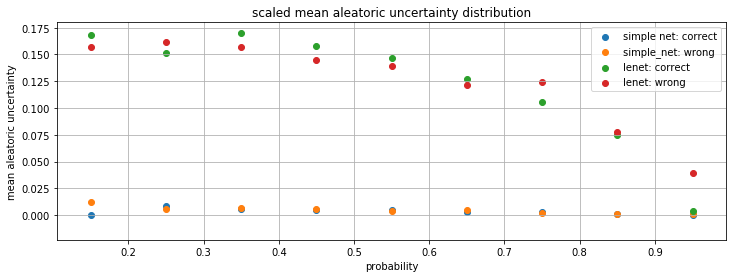

In [96]:
plt.figure(figsize=(12,4))
plt.scatter(prob_s_scale, alea_correct_s_scale, label='simple net: correct')
plt.scatter(prob_s_scale, alea_wrong_s_scale, label='simple_net: wrong')
plt.scatter(prob_l_scale, alea_correct_l_scale,label='lenet: correct')
plt.scatter(prob_l_scale, alea_wrong_l_scale, label='lenet: wrong')
plt.title('scaled mean aleatoric uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean aleatoric uncertainty')
plt.legend()
plt.grid()
plt.show()
plt.close()

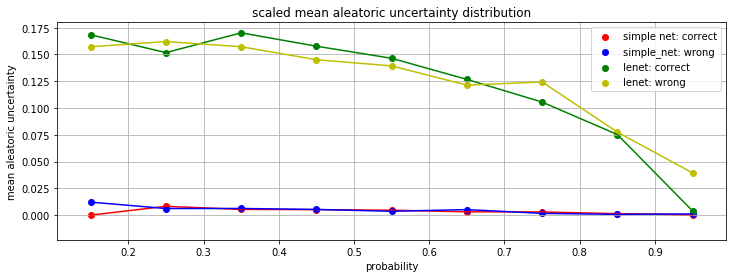

In [166]:
plt.figure(figsize=(12,4))
plt.scatter(prob_s_scale, alea_correct_s_scale, label='simple net: correct', c='r')
plt.scatter(prob_s_scale, alea_wrong_s_scale, label='simple_net: wrong', c='b')
plt.scatter(prob_l_scale, alea_correct_l_scale,label='lenet: correct', c='g')
plt.scatter(prob_l_scale, alea_wrong_l_scale, label='lenet: wrong', c='y')

plt.plot(prob_s_scale, alea_correct_s_scale, c='r')
plt.plot(prob_s_scale, alea_wrong_s_scale, c='b')
plt.plot(prob_l_scale, alea_correct_l_scale, c='g')
plt.plot(prob_l_scale, alea_wrong_l_scale, c='y')
plt.title('scaled mean aleatoric uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean aleatoric uncertainty')
plt.legend()
plt.grid()
plt.show()
plt.close()

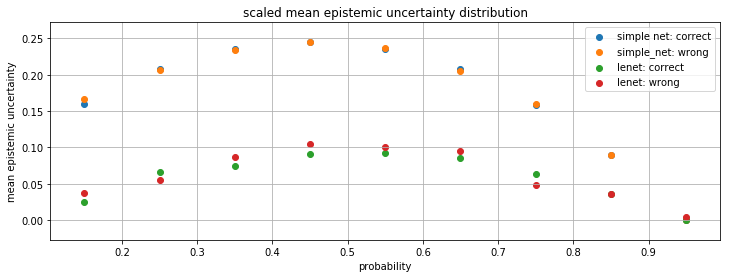

In [98]:
plt.figure(figsize=(12,4))
plt.scatter(prob_s_scale, epis_correct_s_scale, label='simple net: correct')
plt.scatter(prob_s_scale, epis_wrong_s_scale, label='simple_net: wrong')
plt.scatter(prob_l_scale, epis_correct_l_scale,label='lenet: correct')
plt.scatter(prob_l_scale, epis_wrong_l_scale, label='lenet: wrong')
plt.title('scaled mean epistemic uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean epistemic uncertainty')
plt.legend()
plt.grid()
plt.show()
plt.close()

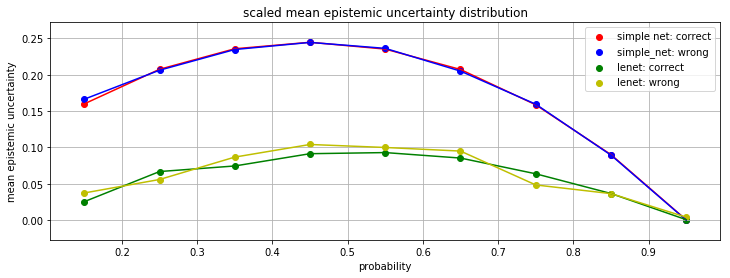

In [167]:
plt.figure(figsize=(12,4))
plt.scatter(prob_s_scale, epis_correct_s_scale, label='simple net: correct', c='r')
plt.scatter(prob_s_scale, epis_wrong_s_scale, label='simple_net: wrong', c='b')
plt.scatter(prob_l_scale, epis_correct_l_scale,label='lenet: correct', c='g')
plt.scatter(prob_l_scale, epis_wrong_l_scale, label='lenet: wrong', c='y')

plt.plot(prob_s_scale, epis_correct_s_scale, c='r')
plt.plot(prob_s_scale, epis_wrong_s_scale, c='b')
plt.plot(prob_l_scale, epis_correct_l_scale, c='g')
plt.plot(prob_l_scale, epis_wrong_l_scale, c='y')

plt.title('scaled mean epistemic uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean epistemic uncertainty')
plt.legend()
plt.grid()
plt.show()
plt.close()

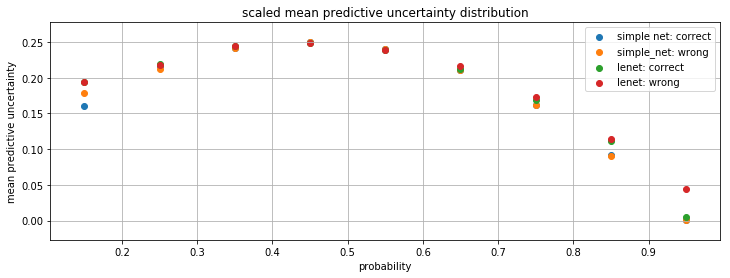

In [99]:
plt.figure(figsize=(12,4))
plt.scatter(prob_s_scale, np.array(alea_correct_s_scale) + np.array(epis_correct_s_scale), label='simple net: correct')
plt.scatter(prob_s_scale, np.array(alea_wrong_s_scale) + np.array(epis_wrong_s_scale), label='simple_net: wrong')
plt.scatter(prob_l_scale, np.array(alea_correct_l_scale) + np.array(epis_correct_l_scale), label='lenet: correct')
plt.scatter(prob_l_scale, np.array(alea_wrong_l_scale) + np.array(epis_wrong_l_scale), label='lenet: wrong')
plt.title('scaled mean predictive uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean predictive uncertainty')
plt.legend()
plt.grid()
plt.show()
plt.close()

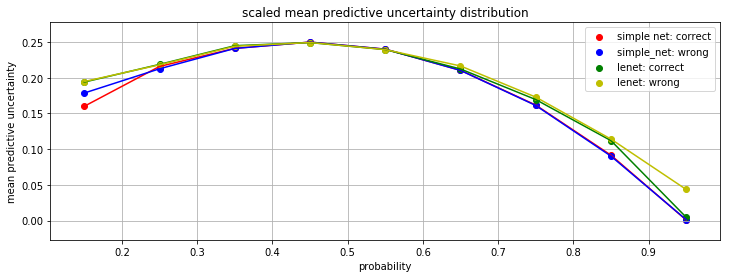

In [168]:
plt.figure(figsize=(12,4))
plt.scatter(prob_s_scale, np.array(alea_correct_s_scale) + np.array(epis_correct_s_scale), label='simple net: correct', c='r')
plt.scatter(prob_s_scale, np.array(alea_wrong_s_scale) + np.array(epis_wrong_s_scale), label='simple_net: wrong', c='b')
plt.scatter(prob_l_scale, np.array(alea_correct_l_scale) + np.array(epis_correct_l_scale), label='lenet: correct', c='g')
plt.scatter(prob_l_scale, np.array(alea_wrong_l_scale) + np.array(epis_wrong_l_scale), label='lenet: wrong', c='y')

plt.plot(prob_s_scale, np.array(alea_correct_s_scale) + np.array(epis_correct_s_scale), c='r')
plt.plot(prob_s_scale, np.array(alea_wrong_s_scale) + np.array(epis_wrong_s_scale), c='b')
plt.plot(prob_l_scale, np.array(alea_correct_l_scale) + np.array(epis_correct_l_scale), c='g')
plt.plot(prob_l_scale, np.array(alea_wrong_l_scale) + np.array(epis_wrong_l_scale), c='y')

plt.title('scaled mean predictive uncertainty distribution')
plt.xlabel('probability')
plt.ylabel('mean predictive uncertainty')
plt.legend()
plt.grid()
plt.show()
plt.close()

In [169]:
simple_aud = average_uncertainty_divergence(alea_correct_s, alea_wrong_s)
print('aud aleatoric uncertainty for unscaled simple net: ', simple_aud)
lenet_aud = average_uncertainty_divergence(alea_correct_l, alea_wrong_l)
print('aud aleatoric uncertainty for unscaled lenet:', lenet_aud)

simple_aud = average_uncertainty_divergence(epis_correct_s, epis_wrong_s)
print('aud epistemic uncertainty for unscaled simple net: ', simple_aud)
lenet_aud = average_uncertainty_divergence(epis_correct_l, epis_wrong_l)
print('aud epistmic uncertainty for unscaled lenet:', lenet_aud)

simple_aud = average_uncertainty_divergence(np.array(alea_correct_s) + np.array(epis_correct_s), np.array(alea_wrong_s)+np.array(epis_wrong_s))
print('aud predictive uncertainty for unscaled simple net: ', simple_aud)
lenet_aud = average_uncertainty_divergence(np.array(alea_correct_l) + np.array(epis_correct_l), np.array(alea_wrong_l) + np.array(epis_wrong_l))
print('aud predictive uncertainty for unscaled lenet:', lenet_aud)

print('=============>')
simple_aud = average_uncertainty_divergence(alea_correct_s_scale, alea_wrong_s_scale)
print('aud aleatoric uncertainty for scaled simple net: ', simple_aud)
lenet_aud = average_uncertainty_divergence(alea_correct_l_scale, alea_wrong_l_scale)
print('aud aleatoric uncertainty for scaled lenet:', lenet_aud)

simple_aud = average_uncertainty_divergence(epis_correct_s_scale, epis_wrong_s_scale)
print('aud aleatoric uncertainty for scaled simple net: ', simple_aud)
lenet_aud = average_uncertainty_divergence(epis_correct_l_scale, epis_wrong_l_scale)
print('aud aleatoric uncertainty for scaled lenet:', lenet_aud)

simple_aud = average_uncertainty_divergence(np.array(alea_correct_s_scale) + np.array(epis_correct_s_scale), np.array(alea_wrong_s_scale)+np.array(epis_wrong_s_scale))
print('aud aleatoric uncertainty for scaled simple net: ', simple_aud)
lenet_aud = average_uncertainty_divergence(np.array(alea_correct_l_scale) + np.array(epis_correct_l_scale), np.array(alea_wrong_l_scale) + np.array(epis_wrong_l_scale))
print('aud aleatoric uncertainty for scaled lenet:', lenet_aud)

aud aleatoric uncertainty for unscaled simple net:  0.0021195008921495173
aud aleatoric uncertainty for unscaled lenet: 0.012898466283721583
aud epistemic uncertainty for unscaled simple net:  0.004898677871096879
aud epistmic uncertainty for unscaled lenet: 0.005589793311498527
aud predictive uncertainty for unscaled simple net:  0.006700931178784231
aud predictive uncertainty for unscaled lenet: 0.01057619322922879
=============>
aud aleatoric uncertainty for scaled simple net:  0.0023468237167334235
aud aleatoric uncertainty for scaled lenet: 0.012907371649311649
aud aleatoric uncertainty for scaled simple net:  0.0015360492769913334
aud aleatoric uncertainty for scaled lenet: 0.00925721856765449
aud aleatoric uncertainty for scaled simple net:  0.002725194242682644
aud aleatoric uncertainty for scaled lenet: 0.005668667015723056


unscaled

In [123]:
x_simple, y_simple = analysis.empirical_cdf_prob(test_loader_mnist, simple_net.guide, shape_simple_net, use_cuda=True)

In [125]:
x_lenet, y_lenet = analysis.empirical_cdf_prob(test_loader_mnist, lenet.guide, shape_lenet, use_cuda=True)

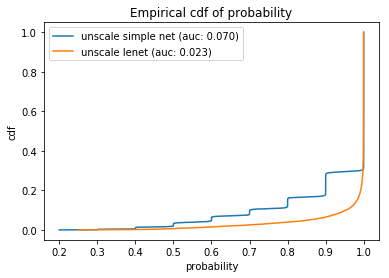

In [126]:
auc_simple = metrics.auc(x_simple, y_simple/y_simple[-1])
auc_lenet = metrics.auc(x_lenet, y_lenet/y_lenet[-1])

plt.figure()
plt.plot(x_simple, y_simple/y_simple[-1], label='unscale simple net (auc: %.3f)'%auc_simple)
plt.plot(x_lenet, y_lenet/y_lenet[-1], label='unscale lenet (auc: %.3f)' % auc_lenet)
plt.title('Empirical cdf of probability')
plt.xlabel('probability')
plt.ylabel('cdf')
plt.legend()
plt.show()
plt.close()

In [128]:
x_lenet, y_lenet = analysis.empirical_cdf_prob(test_loader_mnist, lenet.guide, shape_lenet, use_cuda=True, scale=True, num_class=10)

In [130]:
x_simple, y_simple = analysis.empirical_cdf_prob(test_loader_mnist, simple_net.guide, shape_simple_net, use_cuda=True, scale=True, num_class=10)

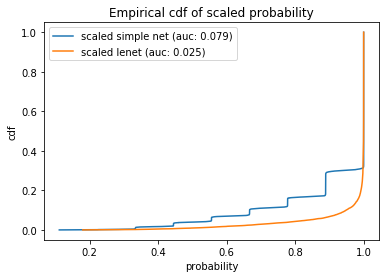

In [136]:
auc_simple = metrics.auc(x_simple, y_simple/y_simple[-1])
auc_lenet = metrics.auc(x_lenet, y_lenet/y_lenet[-1])

plt.figure()
plt.plot(x_simple, y_simple/y_simple[-1], label='scaled simple net (auc: %.3f)'%auc_simple)
plt.plot(x_lenet, y_lenet/y_lenet[-1], label='scaled lenet (auc: %.3f)' % auc_lenet)
plt.title('Empirical cdf of scaled probability')
plt.xlabel('probability')
plt.ylabel('cdf')
plt.legend()
plt.show()
plt.close()